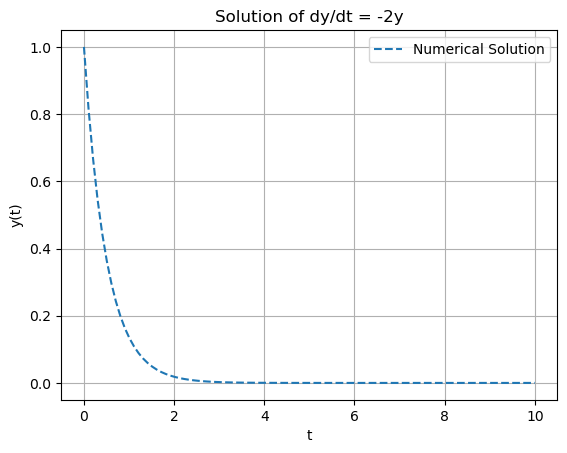

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Define the ODE function
def ode_function(t, y):
    return -2 * y

# Initial condition
y0 = [1]

# Time span for the solution
t_span = (0, 10)  # From t=0 to t=5

# Time points where the solution is computed
t_eval = np.linspace(t_span[0], t_span[1], 100)

# Solve the ODE
solution = solve_ivp(ode_function, t_span, y0, t_eval=t_eval)

# Analytical solution for comparison
y_analytical = np.exp(-2 * t_eval)

# Plotting the results
plt.plot(solution.t, solution.y[0], label='Numerical Solution', linestyle='dashed')
# plt.plot(t_eval, y_analytical, label='Analytical Solution')
plt.xlabel('t')
plt.ylabel('y(t)')
plt.legend()
plt.title('Solution of dy/dt = -2y')
plt.grid(True)
plt.show()

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------------
# 1) Set device to CUDA if available
# -----------------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# -----------------------------------
# 2) Define the neural network model
# -----------------------------------
class PINN(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64, output_dim=1):
        super(PINN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, t):
        # t is shape [N, 1]
        return self.model(t)

Using device: cuda


In [11]:

# -----------------------------------
# 3) Initialize the model on the device
# -----------------------------------
model = PINN().to(device)

# -----------------------------------
# 4) Define constants and optimizer
# -----------------------------------
y_0 = 1.0  # we want y(0) = 2
lr = 1e-3

# Example of adding L2 regularization (weight decay)
# Adjust weight_decay if you find it too large or too small.
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-6)

In [35]:
def loss_function(t_interior, t_bc, y0, lambda_bc):
    """
    t_interior: Collocation points for the ODE
    t_bc: Tensor containing 0.0 for the initial condition
    y0: Desired initial value y(0)
    lambda_bc: Weight for the boundary condition loss term
    """
    # Ensure t_interior and t_bc require gradients
    t_interior.requires_grad_(True)
    t_bc.requires_grad_(True)

    # 1) Predict y(t) at interior points
    y_pred = model(t_interior)
    # print(f"y_pred: {y_pred.detach().cpu().numpy()}")

    # 2) Compute derivative dy/dt using autograd
    y_t = torch.autograd.grad(
        outputs=y_pred,
        inputs=t_interior,
        grad_outputs=torch.ones_like(y_pred),
        create_graph=True
    )[0]
    # print(f"y_t: {y_t.detach().cpu().numpy()}")

    # 3) ODE residual: dy/dt + 2y = 0
    ode_residual = y_t + 2.0 * y_pred
    ode_loss = torch.mean(ode_residual ** 2)
    # print(f"ODE Residual: {ode_residual.detach().cpu().numpy()}")
    # print(f"ODE Loss: {ode_loss.item()}")

    # 4) Boundary condition at t=0: y(0) = y0
    y_bc = model(t_bc)
    bc_loss = (y_bc - y0) ** 2
    # print(f"Boundary Condition Prediction y_bc: {y_bc.item()}")
    # print(f"Boundary Condition Loss: {bc_loss.item()}")

    # 5) Total loss
    total_loss = ode_loss + lambda_bc * bc_loss
    # print(f"Total Loss: {total_loss.item()}")

    return total_loss

In [93]:

# -----------------------------------
# 6) Training loop
# -----------------------------------
num_epochs = 1000
lambda_bc = 1  # weight for boundary condition term

# We'll define t_bc = 0.0 as the boundary point, on device
t_bc = torch.tensor([[0.0]], device=device, requires_grad=False)

for epoch in range(num_epochs):
    # Zero out gradients
    optimizer.zero_grad()
    
    # Sample collocation points in the domain [0, 1]
    # Make sure to place them on the correct device
    t_interior = 1000*torch.rand((1000, 1), dtype=torch.float32, device=device, requires_grad=True)
    
    # Compute the loss
    loss = loss_function(t_interior, t_bc, y_0, lambda_bc=lambda_bc)

    # Backprop & update
    loss.backward()
    optimizer.step()

    # Print progress every 500 epochs
    if epoch % 25 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}")


Epoch 0, Loss: 0.002243
Epoch 25, Loss: 0.001868
Epoch 50, Loss: 0.002018
Epoch 75, Loss: 0.001900
Epoch 100, Loss: 0.001871
Epoch 125, Loss: 0.001906
Epoch 150, Loss: 0.001865
Epoch 175, Loss: 0.001555
Epoch 200, Loss: 0.001614
Epoch 225, Loss: 0.001644
Epoch 250, Loss: 0.001614
Epoch 275, Loss: 0.001002
Epoch 300, Loss: 0.000978
Epoch 325, Loss: 0.000893
Epoch 350, Loss: 0.000811
Epoch 375, Loss: 0.000739
Epoch 400, Loss: 0.000686
Epoch 425, Loss: 0.000635
Epoch 450, Loss: 0.000579
Epoch 475, Loss: 0.000522
Epoch 500, Loss: 0.000483
Epoch 525, Loss: 0.000434
Epoch 550, Loss: 0.000389
Epoch 575, Loss: 0.000371
Epoch 600, Loss: 0.000331
Epoch 625, Loss: 0.000305
Epoch 650, Loss: 0.000286
Epoch 675, Loss: 0.000255
Epoch 700, Loss: 0.000220
Epoch 725, Loss: 0.000205
Epoch 750, Loss: 0.000178
Epoch 775, Loss: 0.000159
Epoch 800, Loss: 0.000123
Epoch 825, Loss: 0.000105
Epoch 850, Loss: 0.000080
Epoch 875, Loss: 0.000057
Epoch 900, Loss: 0.000046
Epoch 925, Loss: 0.000044
Epoch 950, Loss: 

In [94]:

# -----------------------------------
# 7) Testing and comparison
# -----------------------------------
# Test over a larger domain, e.g., [0, 5]
t_test = torch.linspace(0, 1000, 150, device=device).reshape(-1, 1)
with torch.no_grad():
    y_test_pred = model(t_test)


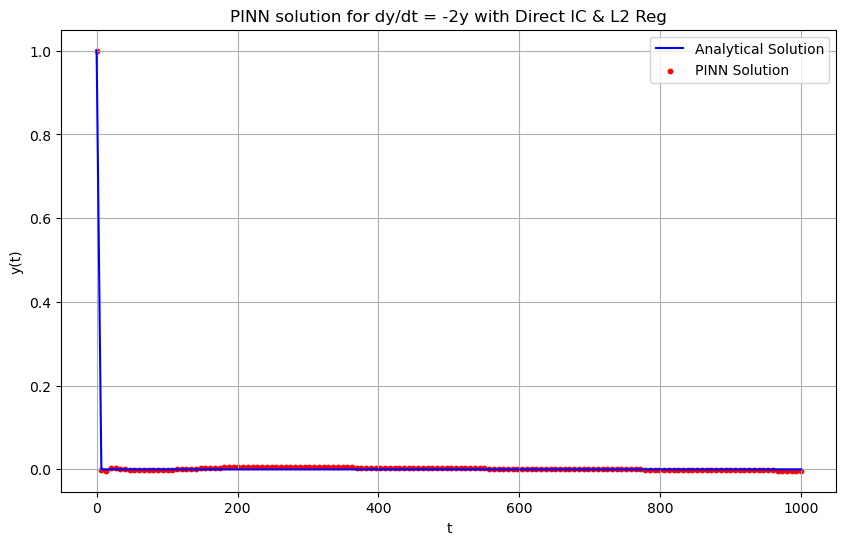

In [95]:

# Move to CPU for plotting
t_test_cpu = t_test.cpu().numpy()
y_test_pred_cpu = y_test_pred.cpu().numpy()

# Analytical solution: y(t) = y0 * exp(-2t)
y_test_true = y_0 * np.exp(-2 * t_test_cpu)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(t_test_cpu, y_test_true, label='Analytical Solution', color='blue')
plt.scatter(t_test_cpu, y_test_pred_cpu, label='PINN Solution', color='red', s=10, marker='o')
plt.xlabel('t')
plt.ylabel('y(t)')
plt.legend()
plt.title('PINN solution for dy/dt = -2y with Direct IC & L2 Reg')
plt.grid(True)
# plt.xlim(0, 100)
plt.show()